# PyMC and Universal Samplers

## Part A: `import pymc`

In [ ]:
import pymc

- [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html)
- [Example Gallary](https://www.pymc.io/projects/examples/en/latest/gallery.html)

In [ ]:
print(f"Running on PyMC v{pymc.__version__}")

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
n = 100
true_theta, true_tau = 0,1
data_generating_mechanism = \
stats.norm(loc=true_theta, scale=true_tau**(-0.5))

x = data_generating_mechanism.rvs(size=n)
plt.hist(x, density=True)
x_grid = np.linspace(-5*true_tau**(-0.5),5*true_tau**(-0.5),1000)
plt.plot(x_grid,data_generating_mechanism.pdf(x_grid));


In [ ]:
conjugate_normal_gamma = pymc.Model()

with conjugate_normal_gamma:

    # Priors for unknown model parameters

    theta0 = 0  # prior belief regarding true_theta
    theta_prior_n = 1  # strength of prior belief as units of data
    # theta_prior_n = tau0/true_tau
    tau0 = theta_prior_n*true_tau
    theta = pymc.Normal("theta", mu=theta0, sigma=tau0**(-0.5))
    # Compared to scipy.stats
    # loc -> mu
    # scale -> sigma but you can also use tau as below...

    tau_SS_prior = 1  # prior belief regarding true_sum_of_squares
    tau_prior_n = 1  # strength of prior belief as units of data
    tau = pymc.Gamma("tau", alpha=tau_prior_n/2,
                            beta=tau_SS_prior/2)
    # https://en.wikipedia.org/wiki/Gamma_distribution
    # pymc.Gamma?
    # Now it's **rate** (beta) NOT scale

    # Likelihood (sampling distribution) of observations
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)

In [ ]:
pymc.model_to_graphviz(conjugate_normal_gamma)

In [ ]:
m = 10000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

## `idata` and `arviz as az`

In [ ]:
idata

In [ ]:
idata.posterior

In [ ]:
idata.posterior['theta']

In [ ]:
idata.posterior['tau']

In [ ]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

In [ ]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

In [ ]:
import arviz as az

In [ ]:
idata

In [ ]:
az.plot_trace(idata, combined=True);

In [ ]:
az.plot_trace(idata)
plt.tight_layout()

In [ ]:
m = 1000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

In [ ]:
# If the messages below don't show
"""Auto-assigning NUTS sampler...
   Initializing NUTS using jitter+adapt_diag...
   Multiprocess sampling (2 chains in 4 jobs)
   NUTS: [theta, tau] """
# You can see this information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

In [ ]:
az.plot_forest(idata, var_names=["theta", "tau"],
               combined=False, hdi_prob=0.95, r_hat=True);


## Part B: Posterior inference and diagnostics<br><sub>with `az.summary`</sub>

In [ ]:
az.summary(idata, round_to=5)#2)

In [ ]:
theta.ravel().shape

### `mean` and `sd`

In [ ]:
round_to=5
theta.ravel().mean().round(round_to), tau.ravel().mean().round(round_to)

In [ ]:
theta.ravel().std().round(round_to), tau.ravel().std().round(round_to)
theta.ravel().std(ddof=1).round(round_to), tau.ravel().std(ddof=1).round(round_to)

### `hdi_3%` and `hdi_97%`

In [ ]:
az.summary(idata, round_to=5)#2)

In [ ]:
np.quantile(theta,[0.05,0.95]).round(round_to)

In [ ]:
np.quantile(theta,[0.025,0.975]).round(round_to)

In [ ]:
np.quantile(theta,[0.03,0.97]).round(round_to)

In [ ]:
# hdi_3% and hdi_97% is something like
# move interval up or down until the smallest interval is found
np.quantile(theta,[0.02,0.96]).round(round_to)

In [ ]:
# so trying to get a bit closer for tau it's someting like
np.quantile(tau,[0.022,0.9622]).round(round_to)

### To consider `mcse_mean` and `mcse_sd`...

- [...moments of moments and first order Taylor series approximation](https://mc-stan.org/posterior/reference/mcse_sd.html)

In [ ]:
az.summary(idata, round_to=5)

In [ ]:
az.summary(idata, round_to=5)['sd']['theta']/\
az.summary(idata, round_to=5)['ess_bulk']['theta']**0.5

In [ ]:
az.summary(idata, round_to=5)['sd']['tau']/\
(az.summary(idata, round_to=5)['ess_bulk']['tau']+0)**0.5

In [ ]:
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']


In [ ]:
# this estimates y which is the variance
((theta.ravel()-theta.ravel().mean())**2).mean()
theta.ravel().var()
# square root of this estimates standard deviation
# s = sqrt(y)

# this estimates variance of y above estimator
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']

# by the delta method
# https://stats.stackexchange.com/questions/491845/how-is-delta-method-used-here-in-approximating-the-square-root-of-a-normal-rando
# var(S) = (1/sqrt(E[Y]))**2 * Var(Y)

((1/theta.ravel().var())*\
 ((theta.ravel()-theta.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['theta'])**0.5

# So it's not quite right...but then again it's maybe not exactly
# https://mc-stan.org/posterior/reference/mcse_sd.html
# "Compute the Monte Carlo standard error for the
#  standard deviation (SD) of a single variable
#  without assuming normality using moments of moments
#  and first order Taylor series approximation
#  (Kenney and Keeping, 1951, p. 141)."

In [ ]:
((1/tau.ravel().var())*\
 ((tau.ravel()-tau.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['tau'])**0.5

In [ ]:
az.summary(idata, round_to=5)

### We must first consider `bulk_tail` and `ess_tail`...

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [ ]:
theta_in_tail = \
(theta<=np.quantile(theta.ravel(),0.05))#+\
(theta>=np.quantile(theta.ravel(),0.95))
print(theta_in_tail.sum()/(2*m))
theta_in_tail

In [ ]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta_in_tail[c,:-t_plus_k],
                    theta_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c))

# effective sample size
approximation_stops=[5,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [ ]:
autocorrelations[:,:10]

In [ ]:
tau_in_tail = \
(tau<=np.quantile(tau.ravel(),0.05))+\
(tau>=np.quantile(tau.ravel(),0.95))
print(tau_in_tail.sum()/(2*m))
tau_in_tail

In [ ]:
m = 1000
K = 30
autocorrelations = np.ones((2,m-1))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau_in_tail[c,:-t_plus_k],
                    tau_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c))

# effective sample size
approximation_stops=[8,6]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())

In [ ]:
autocorrelations[:,:20]

In [ ]:
az.summary(idata, round_to=5)

#### Reminder

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [ ]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta[c,:-t_plus_k],
                    theta[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c))

# effective sample size
approximation_stops=[3,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [ ]:
autocorrelations[:,:10]

In [ ]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau[c,:-t_plus_k],
                    tau[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c))

# effective sample size
approximation_stops=[5,7]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [ ]:
autocorrelations[:,:10]

In [ ]:
az.summary(idata, round_to=5)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(theta.ravel()[:-1], theta.ravel()[1:], '.', alpha=0.25)
ax[1].plot(tau.ravel()[:-1], tau.ravel()[1:], '.', alpha=0.25);

## Part C: R-hat and "energy"

A lack of insufficient "mixing" (agreement) between chains is diagnosed by comparing within and between chain variability. This is done by **checking if the split-$\hat R$ statistic is greater than** $\mathbf{1.05}$. is deemed sufficient when . This is suggestive (but not proof) that the the **Markov chains** have converged to their **stationary distributions**.

> Thus far above we have avoided the notion of "split" chains. Split chains must be considered to ensure that a "drifting chain" does not accidentally pass the $\hat R$ check. Thus the split-$\hat R$ statistic.


$\Large \text{Split-}\hat R  = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $

In [ ]:
az.summary(idata, round_to=5)

In [ ]:
az.plot_trace(idata)
plt.tight_layout()

### Energy

Another diagnostic that sometimes applies is based on the so-called [energy](https://discourse.mc-stan.org/t/help-understanding-bfmi-interpreting-bfmi-1/28554). The exact meaning of "energy" will be discussed next class but for now suffice it to say that when the "Energy transition" fails to dominate the "Marginal energy" the sampler is experiencing a computational bottleneck.


In [ ]:
az.plot_energy(idata);

## Part D: Samplers


In [ ]:
pymc.sample?

In [ ]:
with conjugate_normal_gamma:
    HMC = pymc.HamiltonianMC()
    idata_HMC = pymc.sample(chains=4, step=HMC)

display(az.summary(idata_HMC, round_to=2))
az.plot_trace(idata_HMC)
plt.tight_layout()

In [ ]:
# theta rejection rates
(idata_HMC.posterior.theta.values[:,:-1]==idata_HMC.posterior.theta.values[:,1:]).mean(axis=1)

In [ ]:
# tau rejection rates
(idata_HMC.posterior.tau.values[:,:-1]==idata_HMC.posterior.tau.values[:,1:]).mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_HMC.posterior.theta.values.ravel()[:-1],
           idata_HMC.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_HMC.posterior.tau.values.ravel()[:-1],
           idata_HMC.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

In [ ]:
with conjugate_normal_gamma:
    idata = pymc.sample(chains=4, target_accept=0.9)

display(az.summary(idata, round_to=2))
az.plot_trace(idata)
plt.tight_layout()

In [ ]:
import pandas as pd
display(pd.DataFrame(idata.sample_stats.acceptance_rate))
# rejection rates
1-idata.sample_stats.acceptance_rate.values.mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata.posterior.theta.values.ravel()[:-1],
           idata.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata.posterior.tau.values.ravel()[:-1],
           idata.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

In [ ]:
with conjugate_normal_gamma:
    sampler = pymc.Slice()
    idata_slice = pymc.sample(step=sampler)

display(az.summary(idata_slice, round_to=2))
az.plot_trace(idata_slice)
plt.tight_layout()

In [ ]:
# theta rejection rates
(idata_slice.posterior.theta.values[:,:-1]==idata_slice.posterior.theta.values[:,1:]).mean(axis=1)

In [ ]:
# tau rejection rates
(idata_slice.posterior.tau.values[:,:-1]==idata_slice.posterior.tau.values[:,1:]).mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_slice.posterior.theta.values.ravel()[:-1],
           idata_slice.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_slice.posterior.tau.values.ravel()[:-1],
           idata_slice.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

In [ ]:
with conjugate_normal_gamma:
    MHv1 = pymc.Metropolis(S=np.ones(1), scaling=1, tune=False)
    idata_MHv1 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv1)

display(az.summary(idata_MHv1, round_to=2))
az.plot_trace(idata_MHv1)
plt.tight_layout()

In [ ]:
# theta rejection rates
(idata_MHv1.posterior.theta.values[:,:-1]==idata_MHv1.posterior.theta.values[:,1:]).mean(axis=1)

In [ ]:
# tau rejection rates
(idata_MHv1.posterior.tau.values[:,:-1]==idata_MHv1.posterior.tau.values[:,1:]).mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv1.posterior.theta.values.ravel()[:-1],
           idata_MHv1.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv1.posterior.tau.values.ravel()[:-1],
           idata_MHv1.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

In [ ]:
with conjugate_normal_gamma:
    MHv2 = pymc.Metropolis(S=np.ones(1), scaling=0.1, tune=False)
    idata_MHv2 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv2)

display(az.summary(idata_MHv2, round_to=2))
az.plot_trace(idata_MHv2)
plt.tight_layout()

In [ ]:
# theta rejection rates
(idata_MHv2.posterior.theta.values[:,:-1]==idata_MHv2.posterior.theta.values[:,1:]).mean(axis=1)

In [ ]:
# tau rejection rates
(idata_MHv2.posterior.tau.values[:,:-1]==idata_MHv2.posterior.tau.values[:,1:]).mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv2.posterior.theta.values.ravel()[:-1],
           idata_MHv2.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv2.posterior.tau.values.ravel()[:-1],
           idata_MHv2.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

## Week 5 Homework

---

### Q1: Questions about PyMC...

Complete this formatted markdown listing of the contents of "PyMC Example Gallery". *Include links and your favorite image (right click and "copy image address") from each page.*


#### Introductory

- [General Overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)
- [Simple Linear Regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)
- [General API quickstart](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/ac30f30b2297ec4f2bb798b4f28d2cbba2d0502dbaae4a5f78fdd5cccacda517.svg)|<img src="https://www.pymc.io/projects/docs/en/stable/_images/a8276d1222c43c061dbfff6fa3ff3af15b86038fd7d1e204c429ae3714ea1a20.png"  width="500"/>|![](https://www.pymc.io/projects/examples/en/latest/_images/434538d8660bf2399ebf9df11cbd2b7cec62d8abafc588da625315074b628118.png)|

#### Library Fundamentals
- [Distribution Dimensionality](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/dimensionality.html#dimensionality)
- [PyMC and PyTensor](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_pytensor.html#pymc-pytensor)
- [Using Data Containers](https://www.pymc.io/projects/examples/en/latest/fundamentals/data_container.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/159ea4a9697c6cc6c6912c452dcde08e65ad86f00ebc35d7d202666af6f8fe8c.svg)|![](https://www.pymc.io/projects/docs/en/stable/_images/8c363e9de8872b7ab545c203959bd5958fe2a55761ea45bc391ec893a51c4245.png)|![](https://www.pymc.io/projects/examples/en/latest/_images/988117045fee85ca48b2b5e94ec4b0233a4c23f546d758eaa7bb3c2cd4941720.png)|


#### How-To
- [Prior and Posterior Predictive Checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html#posterior-predictive)
- [Model Comparison](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html#model-comparison)
- [Updating Priors](https://www.pymc.io/projects/examples/en/latest/howto/updating_priors.html)
- [Automatic marginalization of discrete variables](https://www.pymc.io/projects/examples/en/latest/howto/marginalizing-models.html)
- [How to Debug a Model](https://www.pymc.io/projects/examples/en/latest/howto/howto_debugging.html)
- [How to Wrap a JAX Function for Use in PyMC](https://www.pymc.io/projects/examples/en/latest/howto/wrapping_jax_function.html)
- [Splines](https://www.pymc.io/projects/examples/en/latest/howto/spline.html)
- [Bayesian Copula Estimation: Describing Correlated Joint Distributions](https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html)
- [Using ModelBuilder Class for Deploying PyMC Models](https://www.pymc.io/projects/examples/en/latest/howto/model_builder.html)
- [Using a Black Box Likelihood Function](https://www.pymc.io/projects/examples/en/latest/howto/blackbox_external_likelihood_numpy.html)
- [LKJ Cholesky Covariance Priors for Multivariate Normal Models](https://www.pymc.io/projects/examples/en/latest/howto/LKJ.html)
- [Bayesian Missing Data Imputation](https://www.pymc.io/projects/examples/en/latest/howto/Missing_Data_Imputation.html)
- [Profiling](https://www.pymc.io/projects/examples/en/latest/howto/profiling.html)


| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/c30ae812111d855935f054a90acba02cf89c774df6cfb0e6a5f08bccafb47b3e.png)||![](https://www.pymc.io/projects/docs/en/stable/_images/220695e8447f0651dc133a3389ef5d6f586b78e08421f0a2371928118cc909f1.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/5c91b2b45e4e07be744bd90c92793f4b064b85ea9e147b0eaf3b463e1735f34a.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/f2e0b2da5798ac3e36eefd978b3243dff9d416afe6fb3017948a3c350b798c67.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/cd8d49dd3519e25c0ec2d3ef30a0816fe9c3f7708d9eda15d157590da6ca27b5.svg)||![](https://www.pymc.io/projects/examples/en/latest/_images/810705521c6d764cc52621beb88fb0f1160e1a92c804d6708c7c4f84aa34a535.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/fc05f4904f9bc747ae16a7c7037f87b7dc39a480a2a24f0cff56f2ab9f1b9470.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/0f00b23290a12d0321899f684b6108ccac834c6a555112ed39cf7beb7ba88ffa.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/c9989dd8511d1b594a2a82b778f8eea3617da7df1135c6bd3dd174a50acb4e2e.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/profiling.png)|

#### Generalized Linear Models
- [GLM: Robust Linear Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust.html)
- [GLM-ordinal-features](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-ordinal-features.html)
- [Out-Of-Sample Predictions](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-out-of-sample-predictions.html)
- [Bayesian Regression with Truncated or Censored Data](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-truncated-censored-regression.html)
- [Binomial Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-binomial-regression.html)
- [GLM: Negative Binomial Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-negative-binomial-regression.html)
- [Hierarchical Binomial Model: Rat Tumor Example](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-hierarchical-binomial-model.html)
- [A Primer on Bayesian Methods for Multilevel Modeling](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html)
- [GLM-missing-values-in-covariates](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-missing-values-in-covariates.html)
- [Regression Models with Ordered Categorical Outcomes](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-ordinal-regression.html)
- [GLM: Poisson Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-poisson-regression.html)
- [Discrete Choice and Random Utility Models](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-discrete-choice_models.html)
- [GLM: Model Selection](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-model-selection.html)
- [GLM: Robust Regression using Custom Likelihood for Outlier Classification](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust-with-outlier-detection.html)
- [Rolling Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-rolling-regression.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/cca03e23e9627b2fb5f4156cb11fa372d2c3f72389827aa6cfb4f0503abc80ab.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/61fec3699aa82645df4220cd14aa25b7d6553113223e8452da77b7744bb1247a.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/9101d5c4224baf8903f6f99c6d77f2758e5a6069d59d7782cf76b95c573f1049.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/effa77fb83c23871508125eeaebe5b9cf7fa5b81c62e3c350987270737dd7a20.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/47b2df508c92dc27eed40a33b0d251d3b893b2509296aaf89312352c4cbf31c5.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/26e650782d73f95310b3fda053366e4f2a9df307cc35e9ed09f3a2fecc1ed06d.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/02876264b478027ad5229df6fd2030ad6b920fc7092a6c1802da60315485d3f5.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/6139e29ca1cf01883cdc02f6779e87c8fb07fb9e026b5d643927cbb8ccbc3e8c.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/39b62e02913b56f54c4c218aca75b41ef2510bb5a77d80c74a436d545d569b9b.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/8bb9912568ceed44d95b6e2d3e0857e359ac009316f871159363543176486cbf.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/8d70edc186902abbd997ed8155b0807406213a2113a01aff27e3e638b83321eb.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/7f7dc6b81110881a888c14d6532de5f4e5993aad85e141bce5d3ebadfc75590b.svg)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/2abb4b985087a1a8d5f8dfa5b485b34f0134adcceb8cccb3fc9dc0f31ada9047.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/9e30a9295de79f14195c23eef3df8b920c3ff6f79155b9c34a1a2f9842538963.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/22211de6fc61aceeee2dfcaaae455e927576ee9726a8533f6905d51aed63337c.png)|

#### Case Studies
- [Confirmatory Factor Analysis and Structural Equation Models in Psychometrics](https://www.pymc.io/projects/examples/en/latest/case_studies/CFA_SEM.html)
- [Hierarchical Partial Pooling](https://www.pymc.io/projects/examples/en/latest/case_studies/hierarchical_partial_pooling.html)
- [NBA Foul Analysis with Item Response Theory](https://www.pymc.io/projects/examples/en/latest/case_studies/item_response_nba.html)
- [Bayesian Estimation Supersedes the T-Test](https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html)
- [A Hierarchical Model for Rugby Prediction](https://www.pymc.io/projects/examples/en/latest/case_studies/rugby_analytics.html)
- [Estimating Parameters of a Distribution from Awkwardly Binned Data](https://www.pymc.io/projects/examples/en/latest/case_studies/binning.html)
- [Factor Analysis](https://www.pymc.io/projects/examples/en/latest/case_studies/factor_analysis.html)
- [Probabilistic Matrix Factorization for Making Personalized Recommendations](https://www.pymc.io/projects/examples/en/latest/case_studies/probabilistic_matrix_factorization.html)
- [Reliability Statistics and Predictive Calibration](https://www.pymc.io/projects/examples/en/latest/case_studies/reliability_and_calibrated_prediction.html)
- [Generalized Extreme Value Distribution](https://www.pymc.io/projects/examples/en/latest/case_studies/GEV.html)
- [Model Building and Expansion for Golf Putting](https://www.pymc.io/projects/examples/en/latest/case_studies/putting_workflow.html)
- [Fitting a Reinforcement Learning Model to Behavioral Data with PyMC](https://www.pymc.io/projects/examples/en/latest/case_studies/reinforcement_learning.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/db0ad3e27df5db905e86df53ed194c146901e3b038ea44237681fc0471c9d1a2.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/ebc23400283c5ac276dcac1cb83402a474a679bf3963131b9f20349b2c052dea.svg)||![](https://www.pymc.io/projects/examples/en/latest/_images/43a0b14b9f84c62980a32a7eb0b8909d5d78a61305aead0f5bc82109ddb9418b.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/073035d65700ed87439b543ebee2d98e340346030646fed769fb9ec5d135f21f.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/312638f1ea94d2ee490d653b72da1808b07728889ed89fcb1b662ed735207b6b.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/ordinal.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/d3902baec3a16548e994f270bd575d058f63b0919d3aad6bc4b5ab68e650e06d.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/5b2551c6f4199dc0aca603ee728f30c661836b3959edf8ead2848973039ac1c4.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/448f4295ed9f1d2c7e04bb5c578f093f46e0dc3386c6162767050082f92dfa1d.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/6e786fed57136fc0d2a56ff2b214b661ebedd908f407259c2c6d78c63db60e3e.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/a72feff2cfdae8f3edada597bd5b5cacbc41af589de4e02baf98355774c964b1.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/995a216d36052c936298cbb1c1713ab15b14e75aa36c140b1047ad3ef385902f.png)|


#### Causal Inference
- [Simpson’s Paradox](https://www.pymc.io/projects/examples/en/latest/causal_inference/GLM-simpsons-paradox.html)
- [Interrupted Time Series Analysis](https://www.pymc.io/projects/examples/en/latest/causal_inference/interrupted_time_series.html)
- [Regression Discontinuity Design Analysis](https://www.pymc.io/projects/examples/en/latest/causal_inference/regression_discontinuity.html)
- [Interventional Distributions and Graph Mutation with the Do-Operator](https://www.pymc.io/projects/examples/en/latest/causal_inference/interventional_distribution.html)
- [Bayesian Non-Parametric Causal Inference](https://www.pymc.io/projects/examples/en/latest/causal_inference/bayesian_nonparametric_causal.html)
- [Bayesian Mediation Analysis](https://www.pymc.io/projects/examples/en/latest/causal_inference/mediation_analysis.html)
- [Counterfactual Inference: Calculating Excess Deaths due to COVID-19](https://www.pymc.io/projects/examples/en/latest/causal_inference/excess_deaths.html)
- [Introduction to Bayesian A/B Testing](https://www.pymc.io/projects/examples/en/latest/causal_inference/bayesian_ab_testing_introduction.html)
- [Difference in Differences](https://www.pymc.io/projects/examples/en/latest/causal_inference/difference_in_differences.html)
- [Bayesian Moderation Analysis](https://www.pymc.io/projects/examples/en/latest/causal_inference/moderation_analysis.html)



| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/6b57cdc52bee47deb143971dfc654f54d446de92dbd264e0f4820a41a089bc4d.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/e484bdf704fd0f950e188ce71bbb35a8fa14ea627568f8d17aa82e12013dd09e.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/824076ccdb239564ecff17303a90ec60d34065ac9e23f902c1576fce336bdb9d.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/sprinkler.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/78c4cc4e5fe406993c6d10bd6bc8e20b6962242f32dd1c00e037d0c10de92697.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/b8423726013c43fe09cb7ebdddd0bf7b3f51c0749cdc183173b4dc6711013b72.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/6801a496bcbc6c8599a92797e7cae13b1c2e6d03e7ab8cdd479feb7c8f5b76f8.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/df45924e1e38a6f758e57bc367e572f0b3f635b79ce5a2a9c9c7bcd3b0dbed07.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/6be698a56d1eec8ba4cbd0eef5c316721dcf486fb3740423701846a374388b17.svg)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/a26b7b61e4d185410d5e6f0af1da9270397eab627b9040395d4a7fffa8e8b2cd.png)|


#### Gaussian Processes
- [Mean and Covariance Functions](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MeansAndCovs.html)
- [Student-t Process](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-TProcess.html)
- [Heteroskedastic Gaussian Processes](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Heteroskedastic.html)
- [Gaussian Processes: Latent Variable Implementation](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Latent.html)
- [Sparse Approximations](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-SparseApprox.html)
- [Gaussian Processes using numpy kernel](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/gaussian_process.html)
- [Kronecker Structured Covariances](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Kron.html)
- [Example: Mauna Loa CO2](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa2.html)
- [Gaussian Process for CO2 at Mauna Loa](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa2.html)
- [Gaussian Processes: HSGP Reference & First Steps](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa.html)
- [Baby Births Modelling with HSGPs](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Births.html)
- [Marginal Likelihood Implementation](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Marginal.html)
- [Multi-output Gaussian Processes: Coregionalization models using Hadamard product](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/MOGP-Coregion-Hadamard.html)
- [GP-Circular](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Circular.html)
- [Modeling spatial point patterns with a marked log-Gaussian Cox process](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/log-gaussian-cox-process.html)
- [Gaussian Processes: HSGP Advanced Usage](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Advanced.html)
- [Gaussian Process (GP) smoothing](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-smoothing.html#let-s-try-a-linear-regression-first)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/b32dad0edc3b59a6dc6f0da44044b002c11ab9c4e4995b8158637bd766cfad51.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/492abe34d40b745e80b74d46dcc3035d82f0a55b49035bc9dec21e97ceb8b381.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/e232e7d9a039540fb24633a7463866eeab947212b87af65dc9535f55a659c463.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/39603df4f63e88e15dfca57f1eaf6f6aa6385cc08c9e8de8fce0ae99d7ae2162.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/546ae74569c62ee02c96a2605a5b003d0d8df657e30e05f5f0e88c758621c845.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/b3e0033e0eb50e17e785e6a6e73ad21372b0c8dfc1ff73a86e34e9dd17e75f28.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/605deeb9a5cd05d41f170b5c49ddad6f2a9ac06f9da7d90ebe8e9358f179153d.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/c97bb5d41650ef854ebcdc4088fda9f8bd76287973bc2d9951a0f5b6320aafe7.png)||![](http://sites.gsu.edu/geog1112/files/2014/07/MaunaLoaObservatory_small-2g29jvt.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/1b60fee59767da2f31bbbc437e1c4a5ef4a18065d3c4b6e0bd3fe5d2948523e6.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/dac71b44330f1844173b31a6e5886c3f05f44a7f8351d4bef7766a6dc0e5fd4a.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/2447e8ebbc842686109ae1c94a562490c64513eb6923e57e310fd86563d08d66.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/332521cd6ef8034362d2ef31059c06f5fec0b11b4908dae6091530fc5c7e79f4.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/2aec53bbd4d1b612593f50aa4e34bf58b0cd262509590422acdec77e0a3e7913.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/b6c86a8daa0f88300d9775ace3f5d5908f43487ad9d6cd5418669d807bb91e09.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/29f766ff37dd8c96f57a3ba3b3ce68fe574556e0f933601b08ada579b43b7516.svg)||![](https://www.pymc.io/projects/examples/en/latest/_images/dc1ed2831b714f9b6185d286499e101c44fd22ba7fb6e6fcb792554a69deac05.png)|



#### Time Series
- [Longitudinal Models of Change](https://www.pymc.io/projects/examples/en/latest/time_series/longitudinal_models.html)
- [Forecasting with Structural AR Timeseries](https://www.pymc.io/projects/examples/en/latest/time_series/Forecasting_with_structural_timeseries.html)
- [Analysis of An AR(1) Model in PyMC](https://www.pymc.io/projects/examples/en/latest/time_series/AR.html)
- [Stochastic Volatility model](https://www.pymc.io/projects/examples/en/latest/time_series/stochastic_volatility.html)
- [Time Series Models Derived From a Generative Graph](https://www.pymc.io/projects/examples/en/latest/time_series/Time_Series_Generative_Graph.html)
- [Bayesian Vector Autoregressive Models](https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html)
- [Air passengers - Prophet-like model](https://www.pymc.io/projects/examples/en/latest/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html)
- [Multivariate Gaussian Random Walk](https://www.pymc.io/projects/examples/en/latest/time_series/MvGaussianRandomWalk_demo.html)
- [Inferring parameters of SDEs using a Euler-Maruyama scheme](https://www.pymc.io/projects/examples/en/latest/time_series/Euler-Maruyama_and_SDEs.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/cb51b79da3d2ea65a74632f35d3f6fc34ece85c010e19f4603eee7e16a6809fd.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/a72e7a83bd44131c4c544f52c3de3fb4df7aaf7e9b41e35f5981c9868c69b765.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/58d7f2f82cfb880f1711815ffa168839d405b5c9e380a1eeafe1ba3f5995746c.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/56d9b86f30aa0c647022aa147271d4599ce75aae9e90dbd48f9795a36e331f76.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/5afc8ec4b13c99125e5fd7c0621ad2e0b18057693a3a3b94b59b800387db21e4.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/063abe8a9272f0339cf7f3d814d8505c716f95d2846242b4017d6f23a605059b.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/8297658948d7e3289f959ffe989ce27e1b8059ee8a27b4c535723984686f15ff.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/8abe419c7128e466c2389132486abf79812ecde35b96761bbae9164adca7afab.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/2b776f5df4e8a6fc9178a643b8931d320aaddec8810833d406577ab52256f51a.png)|


#### Spatial Analysis
- [The Besag-York-Mollie Model for Spatial Data](https://www.pymc.io/projects/examples/en/latest/spatial/nyc_bym.html)
- [The Prevalence of Malaria in the Gambia](https://www.pymc.io/projects/examples/en/latest/spatial/malaria_prevalence.html)
- [Conditional Autoregressive (CAR) Models for Spatial Data](https://www.pymc.io/projects/examples/en/latest/spatial/conditional_autoregressive_priors.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/9e90708d64b17b75736c36089b5e622a76dd48f5be82a2f4de7f457d964f18dc.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/3e2021a0d3138688f6e1c6e69b99867c6bcecaa5390ed500b9bf3530e08c7f09.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/b0c1efdbaa4abe2e3e02f1fbe1f807c3569663c0a631da625df25b897816bbe8.png)|


#### Diagnostics and Model Criticism
- [Bayes Factors and Marginal Likelihood](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Bayes_factor.html)
- [Diagnosing Biased Inference with Divergences](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html)
- [Sampler Statistics](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/sampler-stats.html)
- [Model Averaging](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/model_averaging.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/28828ea3c7b446eb1d7026396feee37e36b3633b38b38aeeec92e05ca1d8243b.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/241bfe5ad56ca5ac0574fc082f1ea9b775270623877683ecec11df38387f6f2b.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/22641b0dc75f067fdd92a5fbed3e4f3784e9c6598af5cef8e98270d68eaa39b5.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/04dfc13dad24652049eae900d067708b33c326a1cc0a809d54446806b8c88fe5.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/db057b16cc6507be0bf4e84b884be162f7f37c6622887347e3b616418e3b79fe.png)|

#### Bayesian Additive Regression Trees
- [Categorical Regression](https://www.pymc.io/projects/examples/en/latest/bart/bart_categorical_hawks.html)
- [Bayesian Additive Regression Trees: Introduction](https://www.pymc.io/projects/examples/en/latest/bart/bart_introduction.html)
- [Modeling Heteroscedasticity with BART](https://www.pymc.io/projects/examples/en/latest/bart/bart_heteroscedasticity.html)
- [Quantile Regression with BART](https://www.pymc.io/projects/examples/en/latest/bart/bart_quantile_regression.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/73af265de4026405441eda11be375e3d7151e21f4c462b35d83ec3228b43a106.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/799c9ad4685dcfcd9174007a8904d3fb4151861c2e66f93005878b67d6bdd470.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/c7af179be280454fac44e14ae0e2816e1c557090f0962095e05429437c886652.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/02fd8c10f92b70b6972286e64ca3ed546252968ac8c50cd8302923009e50e242.png)|

#### Mixture Models
- [Gaussian Mixture Model](https://www.pymc.io/projects/examples/en/latest/mixture_models/gaussian_mixture_model.html)
- [Dependent Density Regression](https://www.pymc.io/projects/examples/en/latest/mixture_models/dependent_density_regression.html)
- [Dirichlet Process Mixtures for Density Estimation](https://www.pymc.io/projects/examples/en/latest/mixture_models/dp_mix.html)
- [Marginalized Gaussian Mixture Model](https://www.pymc.io/projects/examples/en/latest/mixture_models/marginalized_gaussian_mixture_model.html)
- [Dirichlet Mixtures of Multinomials](https://www.pymc.io/projects/examples/en/latest/mixture_models/dirichlet_mixture_of_multinomials.html)



| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/be9b6ee2d6c50c4472ef2968ae6fab25860073371be2aa29ebade1adf9952628.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/d394806a5d839fa0fa678227efd4e541486045dcdfb4a555b3749705848427b1.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/17564e6effd91fb136066333f821e5b668599aadad298892d88d33dfa6ce101d.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/0262971508f007212fa1dbaaf0a98eadbfecce02383a3133d7a89ed2bfcc0b72.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/6b6315d447e18b6a39f0f24deba8a847271570180c76af83e5ba6da8bc4eb6e6.png)|

#### Survival Analysis
- [Reparameterizing the Weibull Accelerated Failure Time Model](https://www.pymc.io/projects/examples/en/latest/survival_analysis/weibull_aft.html)
- [Bayesian Survival Analysis](https://www.pymc.io/projects/examples/en/latest/survival_analysis/survival_analysis.html)
- [Censored Data Models](https://www.pymc.io/projects/examples/en/latest/survival_analysis/censored_data.html)
- [Frailty and Survival Regression Models](https://www.pymc.io/projects/examples/en/latest/survival_analysis/frailty_models.html)
- [Bayesian Parametric Survival Analysis](https://www.pymc.io/projects/examples/en/latest/survival_analysis/bayes_param_survival.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/5c3c37d792d4ae704ccf9731de2baa51f798257852aef9b91dcb5d1befddadc9.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/faf356a8f5bf2a21353a56a90e7fea6f2795f67b40ca3f56c59ea8ebf91971dd.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/5d33add778ae781898173c0065c76cd136bc93722573ac843c9f89db0a03f7c2.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/1b3a7f46f9456d83bc92730fc4a1ff4548c59a0e7c8c7d8519c3ea7356dcea5c.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/5ba010e4b0eb59d6a9c798094aa32aa4ea4622a8cffc30c32265a6e3cae3e649.png)|

#### ODE Models
- [ODE Lotka-Volterra With Bayesian Inference in Multiple Ways](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html)
- [Lotka-Volterra with Manual Gradients](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_with_manual_gradients.html)
- [PyMC3.ode: Shapes and Benchmarking](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_API_shapes_and_benchmarking.html)
- [GSoC 2019: Introduction of pymc3.ode API](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_API_introduction.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/07e77a972517df91ac84d870e9b2c42ca3c9f6f92420d84a4ef85ff0eb59d895.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/0d4fbd5fcd37f2eb1fef58e953b0291b72fa212c95864b3af07554f3b487f134.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/f1d6ce0b93a1398ab102c7f009b8bf3fc988f78b54f650ccdf4b841fa78b2ea9.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/7774ceeaf7ca87d295b2921716ca9c43c4d094d1ba580111bcea6701cb4eb28e.png)|

#### MCMC
- [Lasso Regression with Block Updating](https://www.pymc.io/projects/examples/en/latest/samplers/lasso_block_update.html)
- [Approximate Bayesian Computation](https://www.pymc.io/projects/examples/en/latest/samplers/SMC-ABC_Lotka-Volterra_example.html)
- [DEMetropolis and DEMetropolis(Z) Algorithm Comparisons](https://www.pymc.io/projects/examples/en/latest/samplers/DEMetropolisZ_EfficiencyComparison.html)
- [Faster Sampling with JAX and Numba](https://www.pymc.io/projects/examples/en/latest/samplers/fast_sampling_with_jax_and_numba.html)
- [Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/samplers/SMC2_gaussians.html)
- [Using a Custom Step Method for Sampling from Locally Conjugate Posterior Distributions](https://www.pymc.io/projects/examples/en/latest/samplers/sampling_conjugate_step.html)
- [DEMetropolis(Z) Sampler Tuning](https://www.pymc.io/projects/examples/en/latest/samplers/DEMetropolisZ_tune_drop_fraction.html)
- [Compound Steps in Sampling](https://www.pymc.io/projects/examples/en/latest/samplers/sampling_compound_step.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/2bc755fd8bf0a29be0c099502d53d2097de89708e8fd4c792426392f28773e1f.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/b3dd5f2e6168f27fbc43c4de6ac4a767b9e2843abcde4fc0ac6387024cfdd936.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/fd0c52f3aa065ef4a1a53be92edc2bda2b37c207975492919379200bef6faec4.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/a6200c084641fcdbddb8dcd934b79899a09357b22b12d743e338ae95127cf922.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/smc.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/aede7ed8b91855a9ffe4fdb579ab4658a52be9906f1364e0281e7af3831406de.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/9b99971997f8422f63937e165d22cba0112e93c0a391029d803ba6fd0fa75e52.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/db057b16cc6507be0bf4e84b884be162f7f37c6622887347e3b616418e3b79fe.png)|

#### Variational Inference
- [Variational Inference: Bayesian Neural Networks](https://www.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html)
- [Pathfinder Variational Inference](https://www.pymc.io/projects/examples/en/latest/variational_inference/pathfinder.html)
- [Empirical Approximation Overview](https://www.pymc.io/projects/examples/en/latest/variational_inference/empirical-approx-overview.html)
- [Introduction to Variational Inference with PyMC](https://www.pymc.io/projects/examples/en/latest/variational_inference/variational_api_quickstart.html)
- [GLM: Mini-batch ADVI on Hierarchical Regression Model](https://www.pymc.io/projects/examples/en/latest/variational_inference/GLM-hierarchical-advi-minibatch.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/cad6382102331ff90c2c382f63af66a7275b32896cbbb27e8ff1d4210c4118a6.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/077012558f2fe2e6b21854e6182b00e824a0d3a00e6df1688d13d20081a76027.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/57f01d3caf90b26ed1a392be29a6d87a4c6a6fd537f9a2650ff983fce3f1acdb.png)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/c9ab10539759da975aa8b8321f20f845e4fa74d348d913b339342682c4dd3aea.png)||![](https://www.pymc.io/projects/examples/en/latest/_images/af9b90617fc072dcb41643f8d1228130d436ae7589248a7adcc8582793cf8ce3.png)|

### Q2: Continue "Q2" of the previous weeks 3 and 4

1. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a normal distribution and your prior for $\tau$ is a gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

2. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a non normal distribution and your prior for $\tau$ is a non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

3. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a yet another different again non normal distribution and your prior for $\tau$ is a yet another different again non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

### Q3: Slice Sampling

*First explain how the Markov algorithm of slice sampling as given below works. Then explain the steps by which slice sampling could be used in place of a Metropolis-Hasting step in a Metropolis within Gibbs algorithm where the full conditionals are only known up to a normalizing constant. In your explanation clarify what the curve that we're sampling beneath is, and what the initial value and steps are to create the draw for Gibbs sampling.*

In [12]:
import scipy.stats as stats

def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):

    # find interval of grid points where f(x_grid) > y
    # then extend the enterval so endpoints f(a)<y and f(b)<y
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid

    x_ = a + stats.uniform().rvs()*(b-a)
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f"
    elif x_ < x:  # or if "x_ was above f on the left side of the interval"
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):

    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)

    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


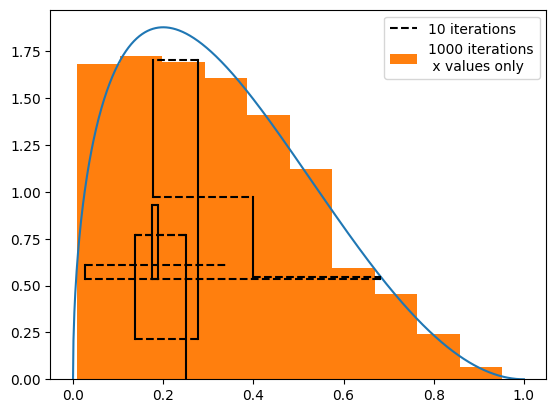

In [13]:
x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))

m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):

    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')

    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')

plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();

Output()

Output()

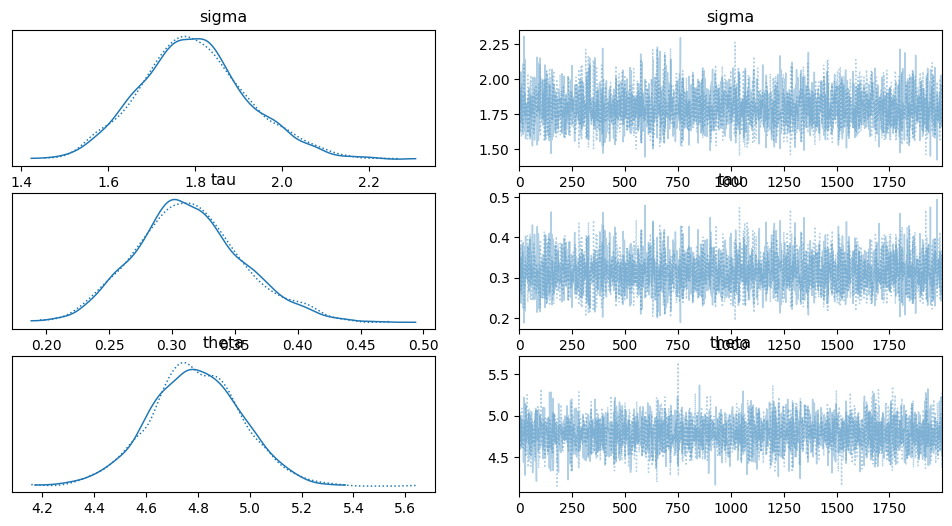

Output()

Output()

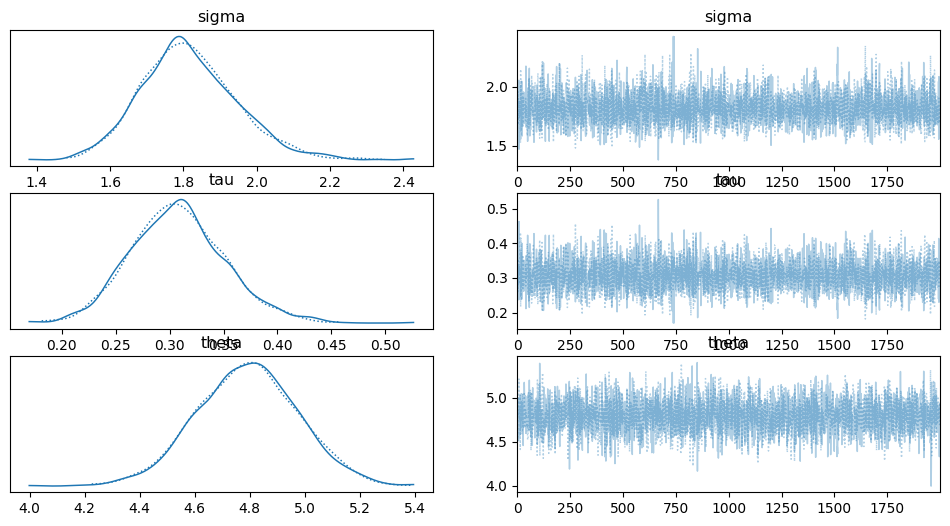

Output()

Output()

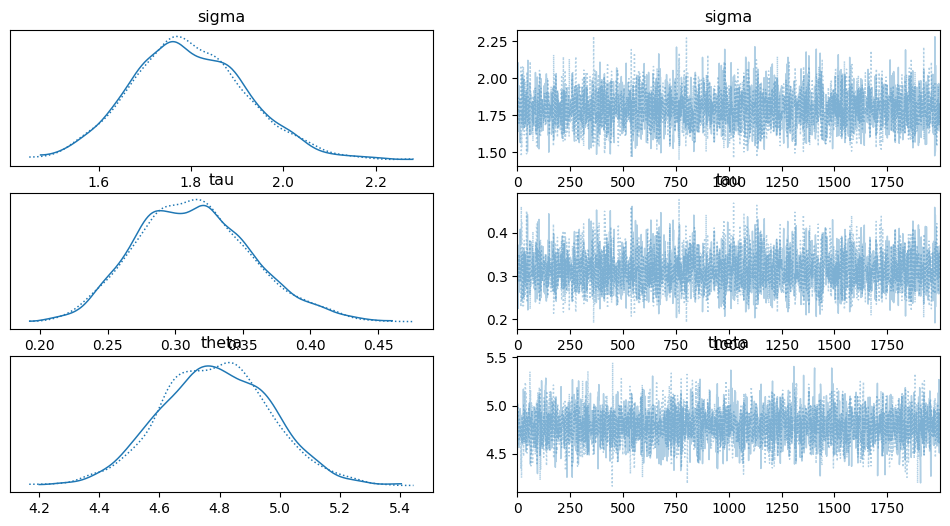

Model 1 Diagnostics


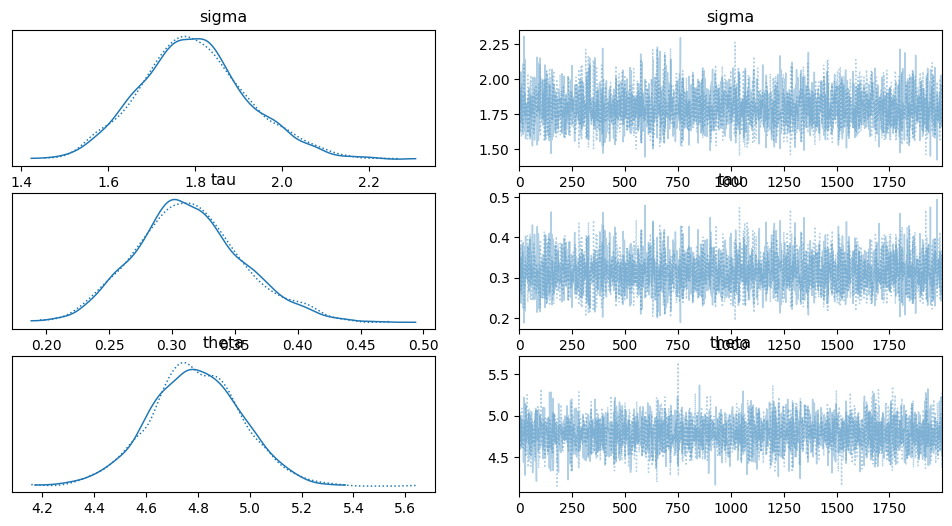

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma  1.798  0.126   1.552    2.022      0.002    0.001    3844.0    2902.0   
tau    0.314  0.044   0.230    0.397      0.001    0.000    3844.0    2902.0   
theta  4.790  0.177   4.454    5.122      0.003    0.002    4276.0    2946.0   

       r_hat  
sigma    1.0  
tau      1.0  
theta    1.0  
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma  1.798  0.126   1.552    2.022      0.002    0.001    3844.0    2902.0   
tau    0.314  0.044   0.230    0.397      0.001    0.000    3844.0    2902.0   
theta  4.790  0.177   4.454    5.122      0.003    0.002    4276.0    2946.0   

       r_hat  
sigma    1.0  
tau      1.0  
theta    1.0  


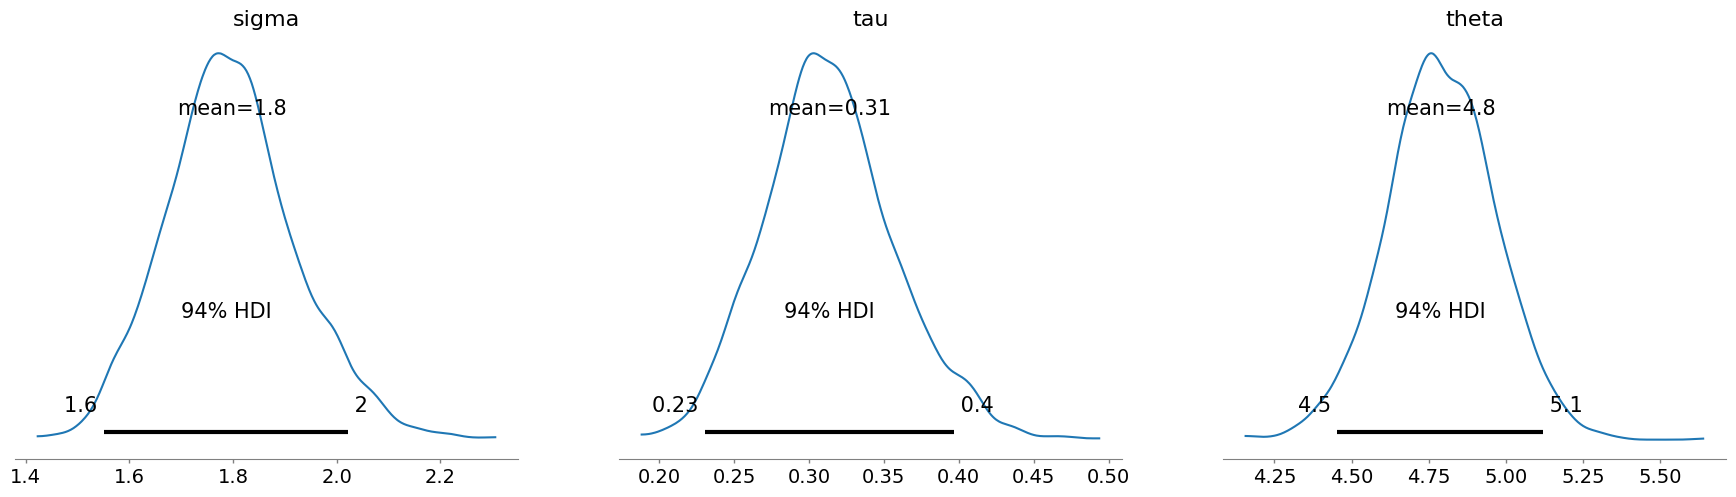

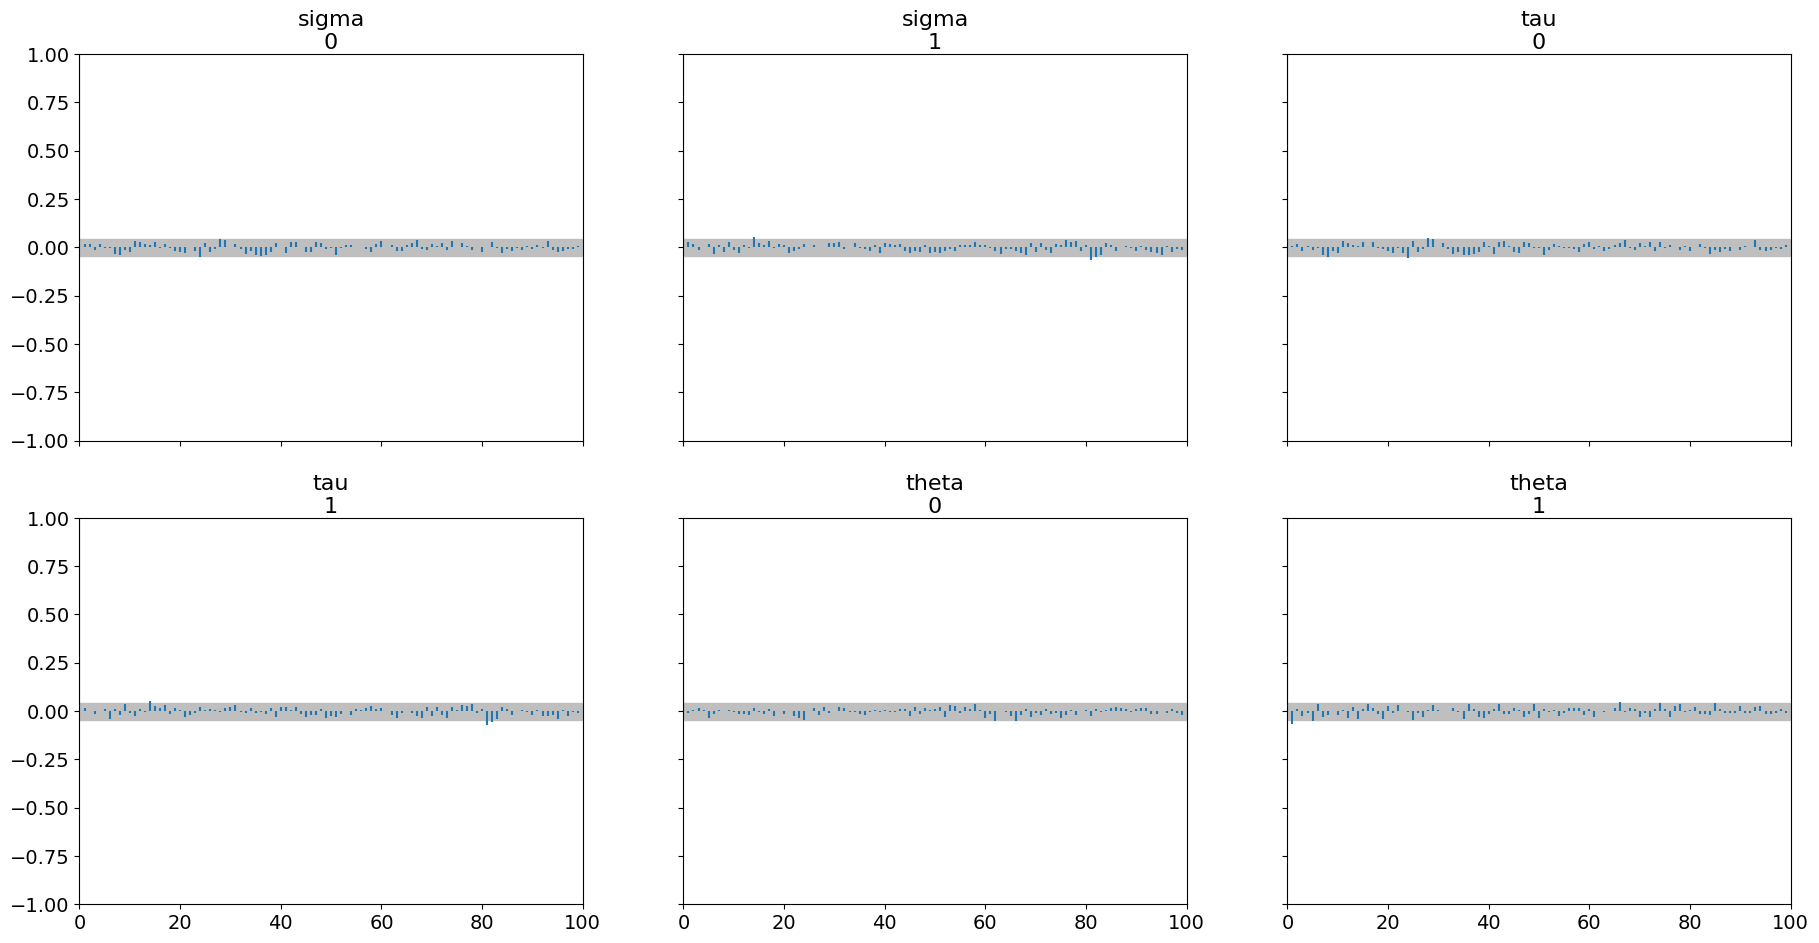

Model 1 Gelman-Rubin: <xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    sigma    float64 8B 1.001
    tau      float64 8B 1.001
    theta    float64 8B 1.001
Model 2 Diagnostics


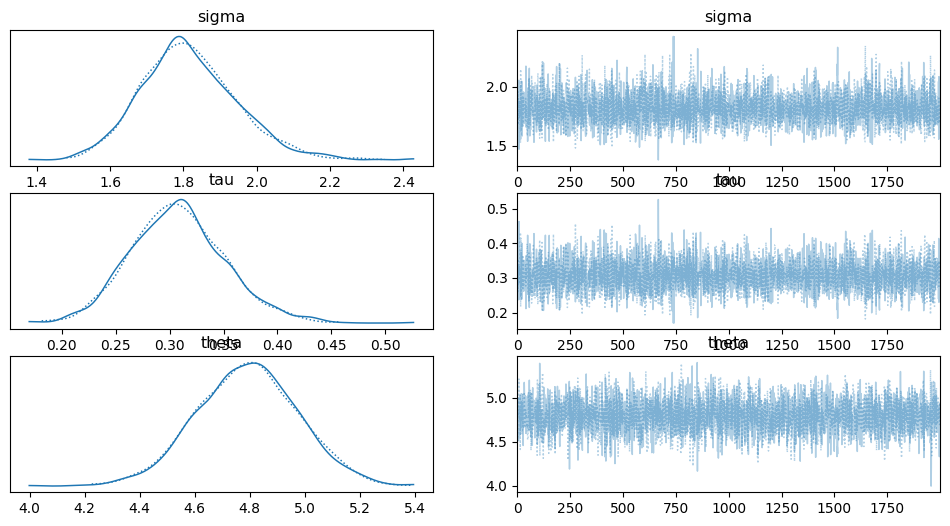

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma  1.816  0.130   1.568    2.051      0.002    0.001    4127.0    2868.0   
tau    0.308  0.043   0.225    0.387      0.001    0.000    4127.0    2869.0   
theta  4.790  0.183   4.457    5.138      0.003    0.002    4000.0    2982.0   

       r_hat  
sigma    1.0  
tau      1.0  
theta    1.0  
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma  1.816  0.130   1.568    2.051      0.002    0.001    4127.0    2868.0   
tau    0.308  0.043   0.225    0.387      0.001    0.000    4127.0    2869.0   
theta  4.790  0.183   4.457    5.138      0.003    0.002    4000.0    2982.0   

       r_hat  
sigma    1.0  
tau      1.0  
theta    1.0  


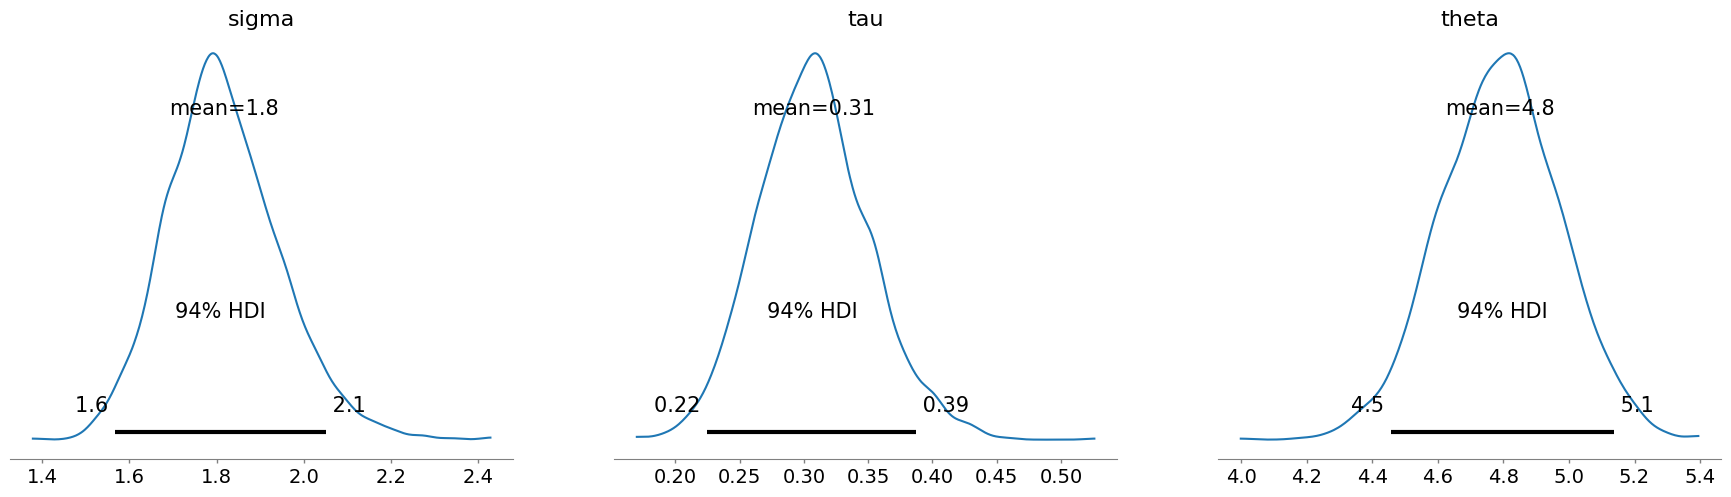

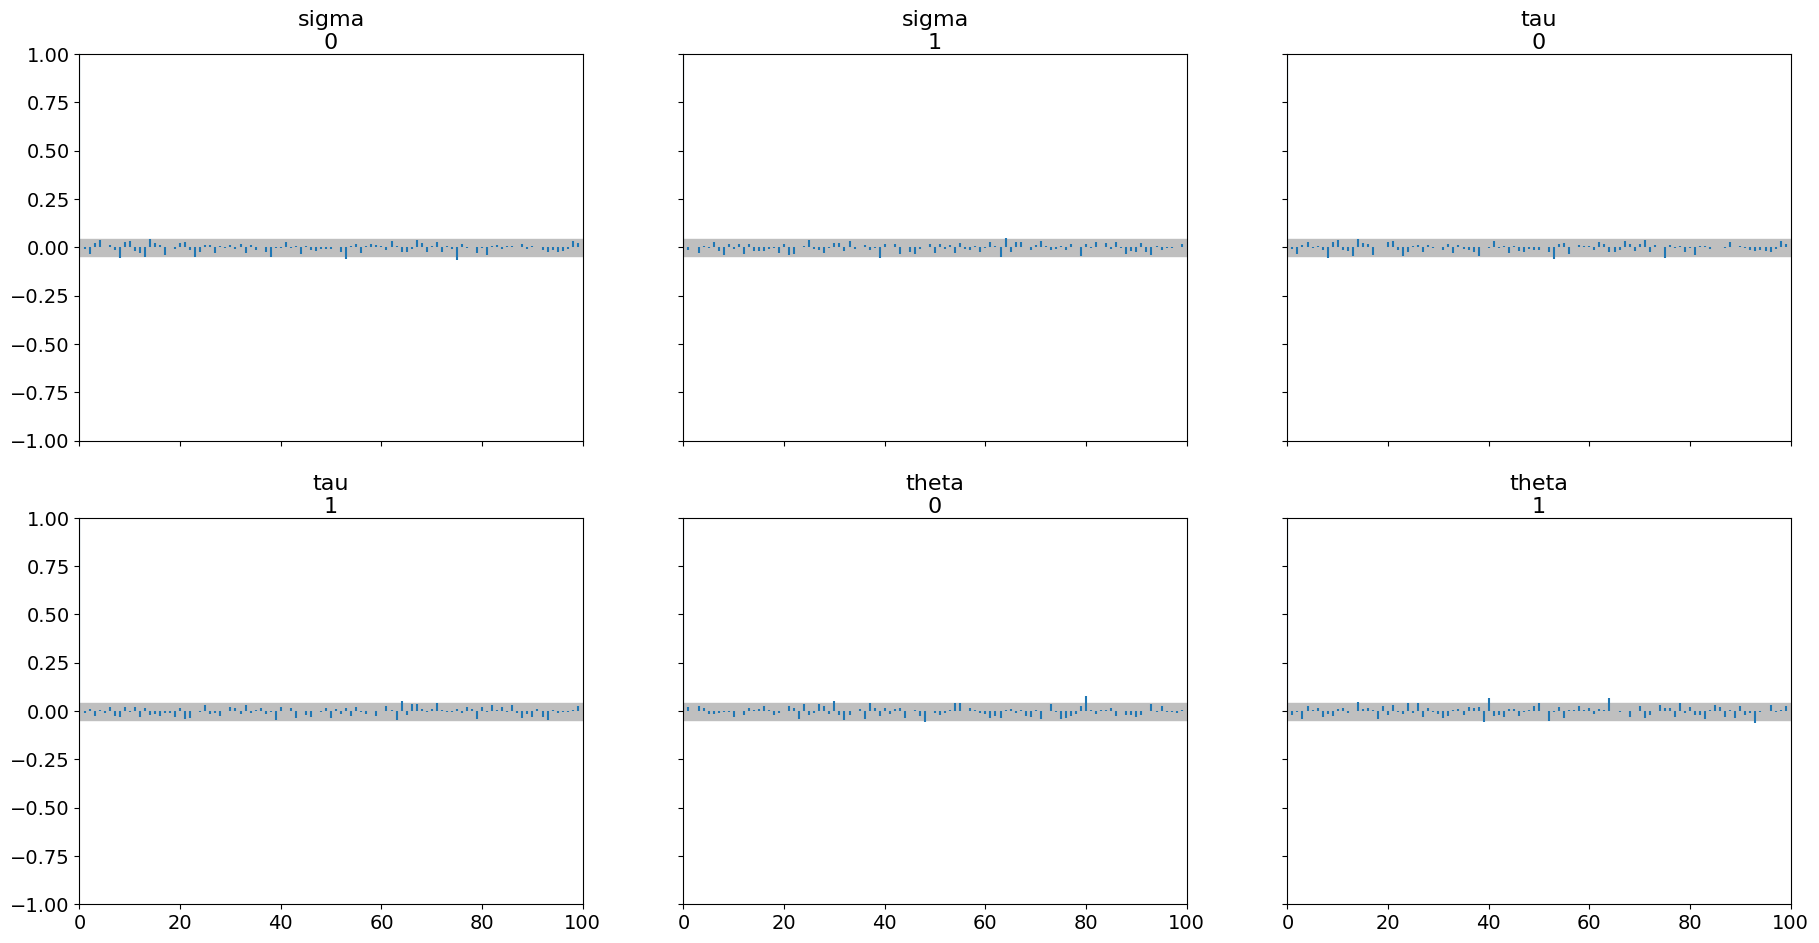

Model 2 Gelman-Rubin: <xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    sigma    float64 8B 1.002
    tau      float64 8B 1.002
    theta    float64 8B 1.0
Model 3 Diagnostics


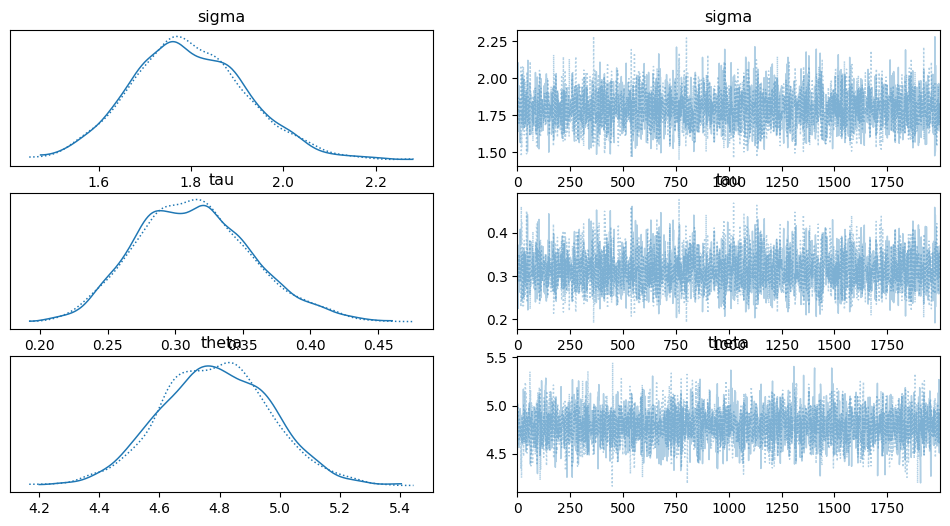

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma  1.796  0.125   1.564    2.032      0.002    0.001    3573.0    2733.0   
tau    0.314  0.044   0.234    0.396      0.001    0.001    3573.0    2733.0   
theta  4.787  0.184   4.458    5.146      0.003    0.002    3709.0    2610.0   

       r_hat  
sigma    1.0  
tau      1.0  
theta    1.0  
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma  1.796  0.125   1.564    2.032      0.002    0.001    3573.0    2733.0   
tau    0.314  0.044   0.234    0.396      0.001    0.001    3573.0    2733.0   
theta  4.787  0.184   4.458    5.146      0.003    0.002    3709.0    2610.0   

       r_hat  
sigma    1.0  
tau      1.0  
theta    1.0  


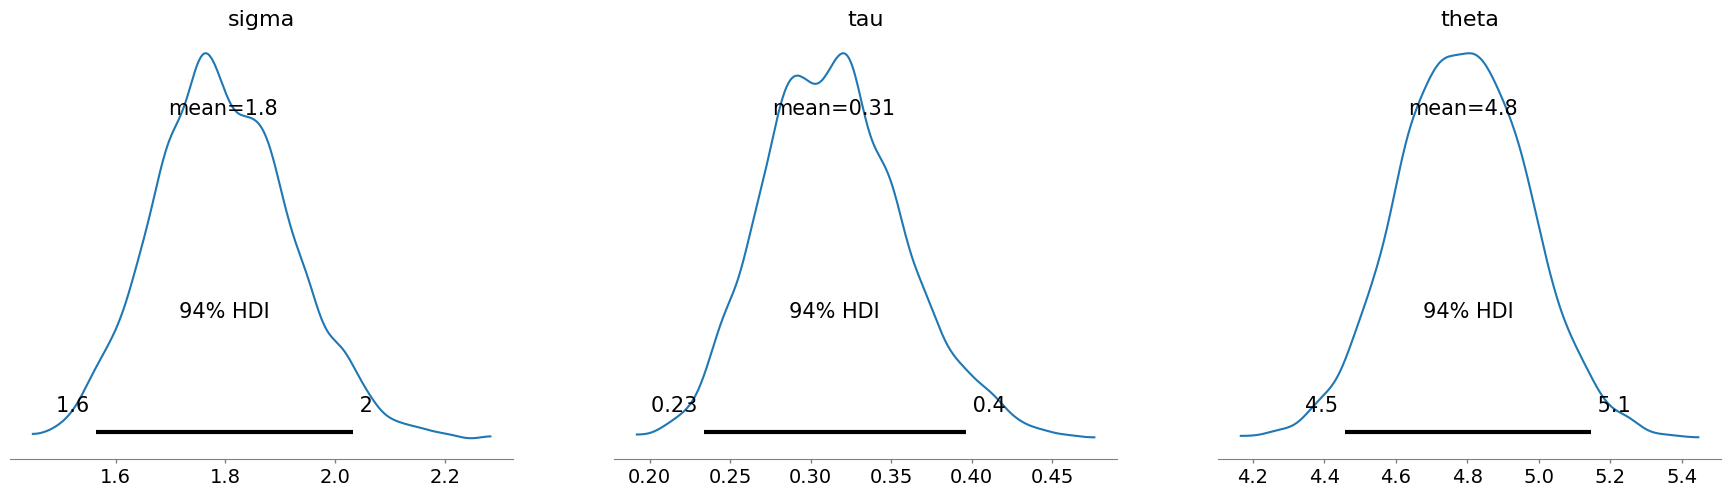

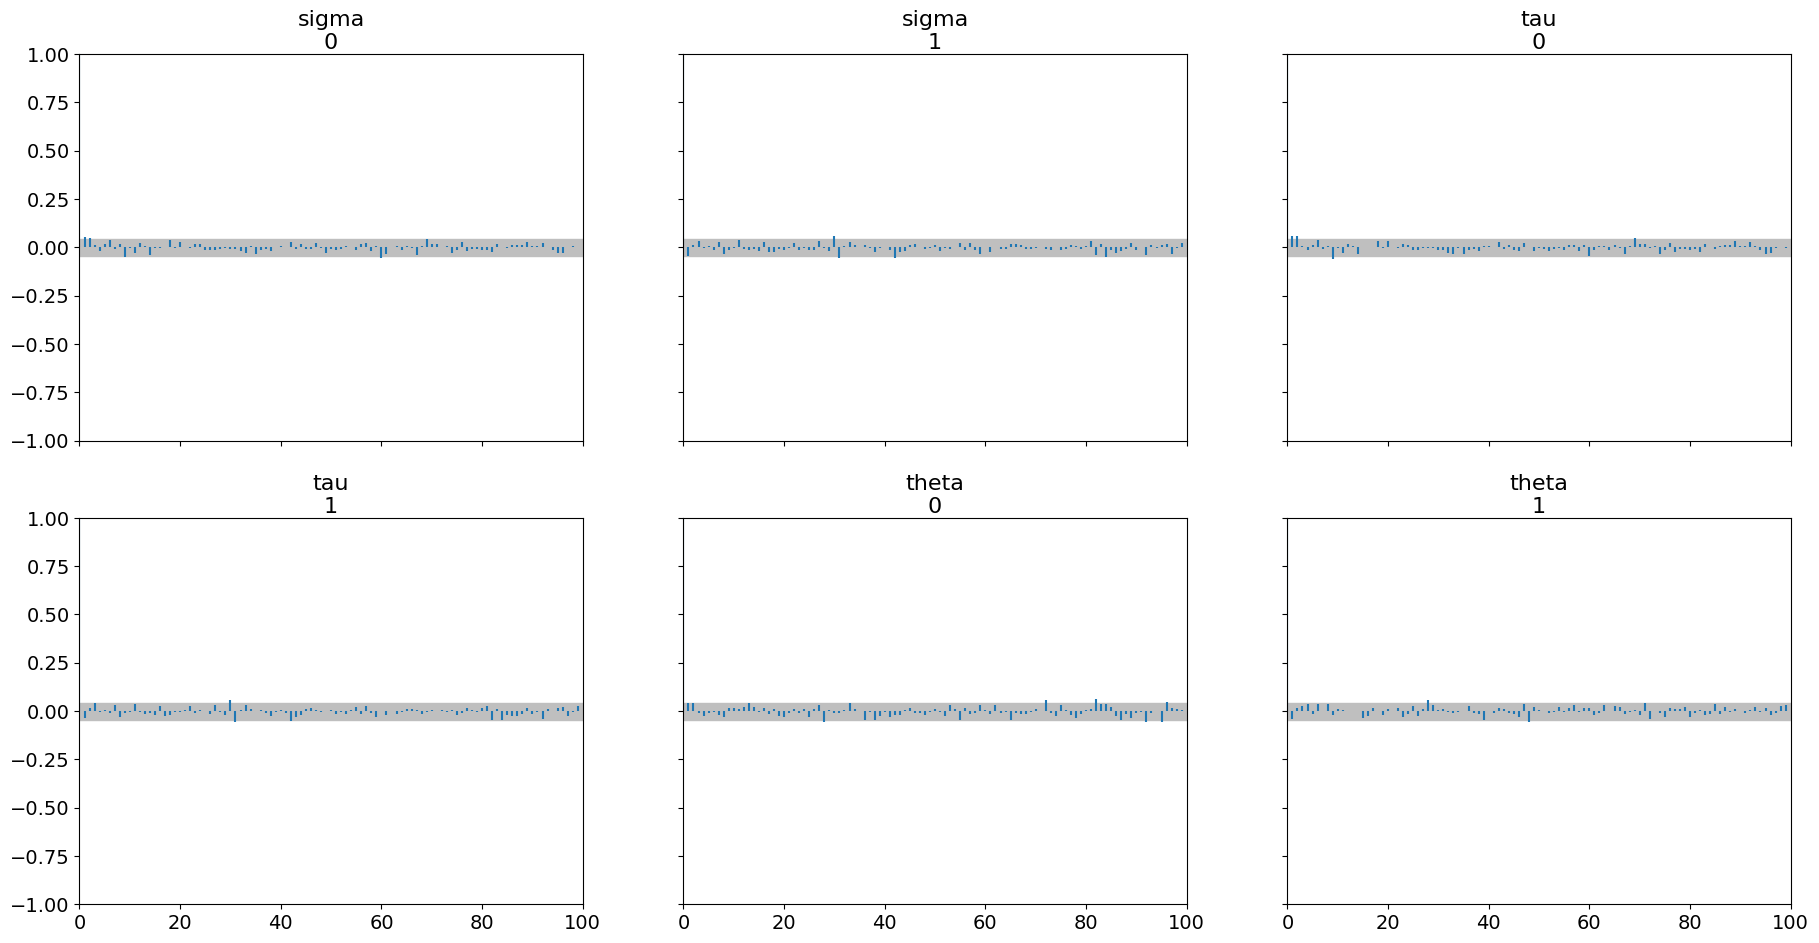

Model 3 Gelman-Rubin: <xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    sigma    float64 8B 1.0
    tau      float64 8B 1.0
    theta    float64 8B 1.0


In [4]:
#Q2 Code

import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Generate synthetic normal data
np.random.seed(42)
data = np.random.normal(loc=5, scale=2, size=100)

# Model 1: Normal prior for theta, Gamma prior for tau
with pm.Model() as model1:
    theta = pm.Normal("theta", mu=0, sigma=10)
    tau = pm.Gamma("tau", alpha=2, beta=1)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))
    likelihood = pm.Normal("obs", mu=theta, sigma=sigma, observed=data)
    trace1 = pm.sample(2000, return_inferencedata=True)
    az.plot_trace(trace1)
    plt.show()

# Model 2: Uniform prior for theta, Exponential prior for tau
with pm.Model() as model2:
    theta = pm.Uniform("theta", lower=-10, upper=10)
    tau = pm.Exponential("tau", lam=1)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))
    likelihood = pm.Normal("obs", mu=theta, sigma=sigma, observed=data)
    trace2 = pm.sample(2000, return_inferencedata=True)
    az.plot_trace(trace2)
    plt.show()

# Model 3: StudentT prior for theta, Lognormal prior for tau
with pm.Model() as model3:
    theta = pm.StudentT("theta", nu=5, mu=0, sigma=10)
    tau = pm.Beta("tau", alpha=2, beta=1)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))
    likelihood = pm.Normal("obs", mu=theta, sigma=sigma, observed=data)
    trace3 = pm.sample(2000, return_inferencedata=True)
    az.plot_trace(trace3)
    plt.show()

# Compare diagnostics
# Diagnostic plots and summaries
for i, trace in enumerate([trace1, trace2, trace3], start=1):
    print(f"Model {i} Diagnostics")
    az.plot_trace(trace)
    plt.show()
    print(az.summary(trace))
    print(az.summary(trace, hdi_prob=0.94))
    az.plot_posterior(trace, hdi_prob=0.94)
    plt.show()
    az.plot_autocorr(trace)
    plt.show()
    print(f"Model {i} Gelman-Rubin:", az.rhat(trace))


## Q3

### 1. Slice sampling

The objective of a Slice sampling programs is to sample from f(x). f(x) here in this case is $Beta(1.5,3)$.

The algorithm is as follow if put simply:

(1) Start: \
 We start with some initial value $x_0$.

(2) Vertical Sampling: \
 At each iteration, we sample a height y uniformly from $[0,f(x)]$. This defines a slice set $S=\{x':f(x')≥y\}$

(3) Horizontal Sampling: \
 We call slice_f_at_y to sample a new $x'$ within the slice S, At this stage, we:\
 Find an initial interval $[a,b]$ where $f(x)>y$ \
 Sample a new $x'$ uniformly from this interval. \
 We accept this $x'$ if $f(x')>y$, or else the interval is made smaller\
 Recursively narrowing the interval $[a,b]$ until a valid $x'$ is found such that $f(x')>y$. \
 output this $x'$ as the sample \

(4) Iteration: \
  Repeat stem (2) and (3) until we have m samples drawn.

### 2. Slice sampling in Gibbs algorithm

Slice sampling can replace the Metropolis-Hastings step in the Metropolis-within-Gibbs algorithm in cases where the full conditional distributions of the parameters are available up to the normalizing constant. Fitting this into Gibbs is straight forward: \

Suppose the target distribution here in this Gibbs is $p(x|y) \propto f(x, y)$, where $f$ is the un-normalized full conditional density that we know of. then we apply slice sampling as we have stated on $x^{(n)}$ and $f$, resulting in $x^{(n+1)}$. Then update y. And we repeat until x and y stabilizes. To initilize $x^{(0)}$, choose any number withinn the support of the target distribution  \

To be clear, the curve we sample beneath here is the un-normalized full conditional density, $f(x,y)$


